# Proyecto Final

Andrea Monzon 23006810 <br>
Juan Pablo Rodas 23007521

1. [Scope del proyecto](#scope)
2. [Lectura de datos](#lectura_datos)
3. [Procesamiento de datos](#procesamiento_datos)
4. [Carga de datos](#carga_datos)

## 1. Scope del proyecto <a id='scope'></a>

El dataset empleado para el proyecto puede encontrarse en el siguiente enlace: [Wine Rating & Price](https://www.kaggle.com/datasets/budnyak/wine-rating-and-price?select=Sparkling.csv)

El set de datos lo constituyen archivos csv de diferentes tipos de vinos (rojo, blanco, rose, etc). Para cada archivo, se encuentran las variables de

* Nombre
* Pais
* Region
* Viñedo
* Calificacion (rating)
* Numero de ratings (cantidad de personas que calificaron el vino)
* Precio
* Año

Las preguntas que resolveremos en este notebook serán respecto a qué correlación tienen ciertas variables con el rating del vino, la cual sería nuestra variable "objetivo", así como preguntas de qué rating se tiene por países, qué año tiene el mejor rating, etc.

## 2. Lectura de datos <a id='lectura_datos'></a>

Primero importaremos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import boto3
import configparser
import psycopg2

In [2]:
config = configparser.ConfigParser()
config.read('./escec.cfg')

['./escec.cfg']

Importaremos nuestros 3 scripts de Python separados para los objetivos de
* Extraer/leer los datos desde RDS y S3
* Procesar/transformar los datos
* Cargar los datos limpios en el bucket de S3 (Data Lake)

Los datos del dataset de kaggle fueron cargados previamente a la ejecucion de este notebook
* La creacion de la DB en RDS, la tabla correspondiente y datos para el vino rose puede verse en este [notebook dentro del proyecto](./preparation/preparacion_fuentes_de_datos.ipynb)
* Los archivos CSV para el vino rojo y blanco, fueron subidos directamente desde la consola de AWS

In [3]:
import sys
sys.path.insert(0, './scripts')
import extract, process, load

In [4]:
rose_df = extract.extractRDS(config) #lectura de la DB en RDS

proyectofinal.cvmhjcquzuf7.us-east-1.rds.amazonaws.com


In [5]:
rose_df.head()

,name,country,region,winery,rating,numberofratings,price,year
0,Mad Méditerranée Rosé 2019,France,Méditerranée,Château Camparnaud,4.0,25,10.11,2019
1,Redoma Rosé 2019,Portugal,Douro,Niepoort,3.9,25,12.81,2019
2,Fantini Cerasuolo d'Abruzzo 2019,Italy,Abruzzo,Farnese,3.6,25,5.60,2019
3,Mount Hermon Rosé 2017,Israel,Galilee,Hermon,3.4,25,12.14,2017
4,La Villa Rosé 2018,France,Languedoc,Château La Sauvageonne,4.6,25,68.95,2018


In [6]:
red_df, white_df= extract.extractS3(config)

In [7]:
red_df.head()

,name,country,region,winery,rating,numberofratings,price,year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [8]:
white_df.head()

,name,country,region,winery,rating,numberofratings,price,year
0,Vermentino 2017,Italy,Toscana,Famiglia Castellani,3.8,25,5.65,2017
1,Ronco Broilo 2010,Italy,Colli Orientali del Friuli,Conte d'Attimis Maniago,4.3,25,44.90,2010
2,Weisser Schiefer s 2017,Austria,Südburgenland,Weinbau Uwe Schiefer,4.2,25,33.25,2017
3,Chardonnay 2018,Germany,Rheinhessen,Krämer - Straight,3.9,25,8.99,2018
4,Maganza Zibibbo 2018,Italy,Terre Siciliane,Luna Gaia,3.9,25,8.60,2018


## 3. Procesamiento de datos <a id='procesamiento_datos'></a>

Ahora procesamos los datos con el script correspondiente, que unira los 3 dataset en un unico dataframe, transformara algunas columnas y agregara un atributo "type" para indicar el tipo de vino

In [9]:
complete_df = process.data_processing(red_df, rose_df, white_df)

In [10]:
complete_df.head()

,name,country,region,winery,rating,numberofratings,price,year,type
0,Pomerol 2011,France,Pomerol,Chateau La Providence,4.2,100,95.00,2011,Red
1,Lirac 2017,France,Lirac,Chateau Mont-Redon,4.3,100,15.50,2017,Red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,Red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,Red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,Red


## 4. Carga de datos <a id='carga_datos'></a>

Ahora cargamos los datos en S3

In [12]:
load.load_to_dl(complete_df, "proyectofinal-us-east-1-665777243823", 'results/wine_complete_df.csv', config)

## 5. Analitica

### I) Existe coorelacion entre el rating de los vinos y su año de fabricacion

Corr year: -0.33478152226986546


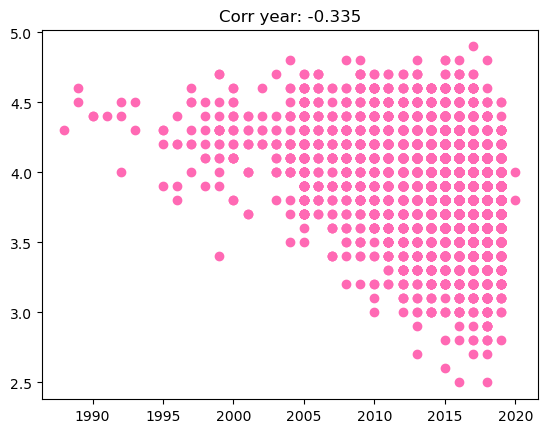

In [14]:
colName = 'year'
df_temp = complete_df.drop(complete_df[ complete_df['year'] == 0].index)

corr = df_temp[colName].corr(df_temp["rating"])
print(f"Corr {colName}: {corr}")
plt.scatter(df_temp[colName],df_temp["rating"], color = 'hotpink')
plt.title(f"Corr {colName}: {'%.3f' % corr}")
plt.show()

segun la grafica y el coeficiente de coorelacion (que no es cercano a uno) no existe una relacion lineal entre el año de fabricacion y el rating de los vinos

### II) Existe coorelacion entre el rating de los vinos y su precio

Corr price: 0.4723532779528008


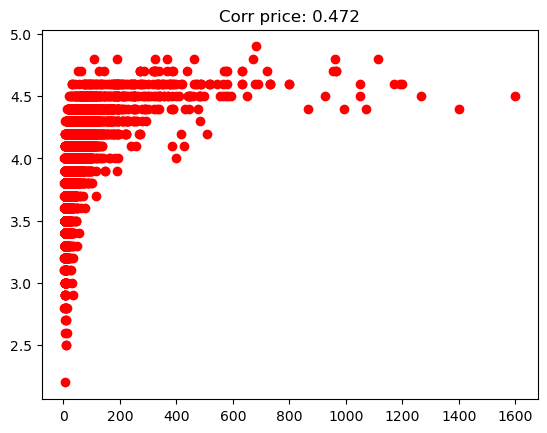

In [16]:
colName = 'price'
df_temp = complete_df.drop(complete_df[ complete_df['price'] > 2500].index)

corr = df_temp[colName].corr(df_temp["rating"])
print(f"Corr {colName}: {corr}")
plt.scatter(df_temp[colName],df_temp["rating"], color = 'red')
plt.title(f"Corr {colName}: {'%.3f' % corr}")
plt.show()

segun la grafica y el coeficiente de coorelacion que es de 0.472, existe una ligera relacion lineal entre el precio de los vinos y el rating de los mismos

### III) Que pais tendra mayor numero de vinos producidos con rating mayor a 4.5 

In [23]:
complete_df.loc[complete_df['rating'] > 4.5][['country','rating']].groupby('country').count().sort_values('rating', ascending=False).reset_index()

,country,rating
0,Italy,49
1,France,46
2,Spain,16
3,United States,15
4,Argentina,6
5,Germany,4
6,Portugal,4
7,South Africa,4
8,Australia,3
9,Chile,3


Es Italia el pais que tiene mas vinos con rating por encima de 4.5

### IV) Que pais tendra el mayor numero de vinos con rating menor a 3

In [22]:
complete_df.loc[complete_df['rating'] < 3][['country','rating']].groupby('country').count().sort_values('rating', ascending=False).reset_index

<bound method DataFrame.reset_index of                rating
country              
Italy               6
France              4
South Africa        3
Austria             2
Brazil              2
Greece              2
Argentina           1
Chile               1
China               1
Spain               1
United States       1>

Es Italia el pais que tiene mas vinos con un rating por debajo de 3, probablemente porque es el pais que tine mas tiene dentro ded la base de datos

### V) En promedio que pais tiene los vinos con mejor rating

In [21]:
complete_df[['country','rating']].groupby('country').mean().sort_values('rating', ascending=False).reset_index().head(10)

,country,rating
0,Moldova,4.150000
1,Lebanon,4.137500
2,Croatia,4.083333
3,Czech Republic,4.050000
4,Georgia,3.976923
5,France,3.920671
6,Italy,3.890801
7,United States,3.888145
8,Germany,3.870200
9,Portugal,3.864134


en promedio Moldova genera los vinos con mejor rating

### VI) Que viñeros producen mas vinos

In [77]:
res = (complete_df.groupby(['winery']).agg({'winery': ['count']}))
res.columns = [ ' '.join(str(i) for i in col) for col in res.columns]
res.sort_values(by='winery count', ascending=False).head(10).reset_index()

,winery,winery count
0,Markus Molitor,72
1,Errazuriz,58
2,Torres,54
3,Joseph Drouhin,51
4,Gaja,42
5,M. Chapoutier,42
6,Paul Jaboulet Aine,36
7,E. Guigal,36
8,Antinori,35
9,Von Winning,34


vemos el listado de los 10 viñeros que producen mas vinos dentro del data frame

### VII) el top 10 de mejores vinos de cada tipo segun rating

#### Rojo

In [63]:
DataSort=complete_df[complete_df['type']=='Red']
DataSort[['name','country','rating','type']].sort_values('rating', ascending=False).reset_index().head(10)

,index,name,country,rating,type
0,3420,G 2015,South Africa,4.8,Red
1,3747,Beckstoffer Las Piedras Vineyard Cabernet Sauv...,United States,4.8,Red
2,8086,Veneto Alzero Cabernet 2009,Italy,4.8,Red
3,4031,L'Ermita Velles Vinyes Priorat 2008,Spain,4.8,Red
4,951,Barolo Riserva Monfortino 2013,Italy,4.8,Red
5,8073,Toscana 2016,Italy,4.8,Red
6,2044,Unico 2006,Spain,4.7,Red
7,8554,Margaux (Grand Cru Classe) 2005,France,4.7,Red
8,7313,Saint-Julien (Grand Cru Classe) 2009,France,4.7,Red
9,253,Promontory 2013,United States,4.7,Red


#### Blanco

In [64]:
DataSort=complete_df[complete_df['type']=='White']
DataSort[['name','country','rating','type']].sort_values('rating', ascending=False).reset_index().head(10)

,index,name,country,rating,type
0,9604,Montrachet Grand Cru Marquis de Laguiche 2017,France,4.9,White
1,10073,Ermitage de l'Oree 2004,France,4.8,White
2,10270,The Wine Collection Sauvignon 2016,Italy,4.7,White
3,10828,Wehlener Sonnenuhr Riesling Auslese 2015,Germany,4.6,White
4,11549,Kirchspiel Riesling GG 2012,Germany,4.6,White
5,11183,Kirchspiel Riesling GG 2015,Germany,4.6,White
6,11772,Vieilles Vignes Chateauneuf-du-Pape Blanc 2014,France,4.6,White
7,10272,Zeltinger Schlossberg Riesling Trockenbeerenau...,Germany,4.6,White
8,11049,Corton-Charlemagne Grand Cru 2015,France,4.6,White
9,9556,Batard-Montrachet Grand Cru 2015,France,4.6,White


#### Rose

In [66]:
DataSort=complete_df[complete_df['type']=='Rose']
DataSort[['name','country','rating','type']].sort_values('rating', ascending=False).reset_index().head(10)

,index,name,country,rating,type
0,8743,Garrus Rose 2018,France,4.8,Rose
1,8670,La Villa Rose 2018,France,4.6,Rose
2,8720,281 Rose 2019,France,4.5,Rose
3,8714,Clos Beylesse Cotes de Provence Rose 2019,France,4.5,Rose
4,8806,Clos du Temple 2018,France,4.5,Rose
5,8838,Les Clans Rose 2018,France,4.4,Rose
6,8902,Clos Beylesse Cotes de Provence Rose 2018,France,4.3,Rose
7,9002,Rose et Or 2019,France,4.3,Rose
8,8923,Les Clans Rose 2017,France,4.3,Rose
9,8736,Der Elefant im Porzellanladen 2019,Austria,4.3,Rose


### VIII) los 10 mejores vinos Argentinos

In [73]:
DataSort=complete_df[complete_df['country']=='Argentina']
DataSort[['name','country','rating','type']].sort_values('rating', ascending=False).reset_index().head(10)

,index,name,country,rating,type
0,1973,Adrianna Vineyard Mundus Bacillus Terrae Malbe...,Argentina,4.6,Red
1,5185,Gran Enemigo Single Vineyard Gualtallary Caber...,Argentina,4.6,Red
2,123,Bramare Rebon Vineyard Malbec 2017,Argentina,4.6,Red
3,265,Adrianna Vineyard Fortuna Terrae Malbec 2016,Argentina,4.6,Red
4,945,Malbec Argentino 2017,Argentina,4.6,Red
5,1275,Bramare Marchiori Vineyard Malbec 2017,Argentina,4.6,Red
6,7974,Gran Enemigo Single Vineyard El Cepillo Cabern...,Argentina,4.5,Red
7,4638,Bramare Marchiori Vineyard Malbec 2016,Argentina,4.5,Red
8,12033,Adrianna Vineyard White Stones Chardonnay 2015,Argentina,4.5,White
9,3359,Adrianna Vineyard Fortuna Terrae Malbec 2013,Argentina,4.5,Red
